In [1]:
# Parameters
num_cores = 27
mem = 650000
config = "configs.config_Reddit"


In [2]:
#!/usr/bin/env python
# coding: utf-8

if 'config' not in locals():
    config = 'configs.config_SE_test_local'
#     config = 'configs.config_Reddit_test_local'

In [3]:
### initialization ###

from _imports import *
# from _utils import *

print('config file is set to {}'.format(config))

util=importlib.import_module('_utils')
importlib.reload(util)

c=importlib.import_module(config)
importlib.reload(c)

get_ipython().run_line_magic('matplotlib', 'inline')

# param_setup(sys.argv[1:], c)
util.param_setup_ipython(globals(), c)

config file is set to configs.config_Reddit
num_cores is set to 27
mem is set to 650000


,coherence,num_topics
29,0.658394,62
32,0.657229,68
28,0.656223,60
47,0.655975,98
48,0.655750,100


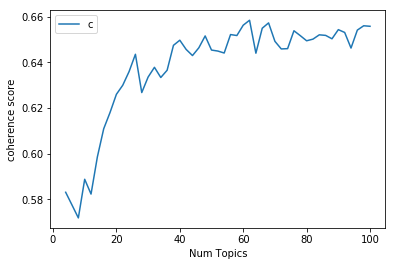

In [4]:
### Plotting coherence values ###

if c.hist_filenames is not None and len(c.hist_filenames) > 0:
    data=pd.DataFrame()
    try:
        for filename in c.hist_filenames:
            data = pd.concat([data,
                              pd.read_csv(c.directory['save']+filename)
                             ], 
                             axis=0,
                             ignore_index=True
                            )


#         util.display_df(data)
        if len(data) > 0 :
            data=data.sort_values(['num_topics'])
            util.display_df(data.sort_values(['coherence'], ascending=False).head(min(5, len(data))))
            x = data['num_topics']
            y = data['coherence']
            plt.plot(x, y)
            plt.xlabel("Num Topics")
            plt.ylabel("coherence score")
            plt.legend(("coherence_values"), loc='best')
            plt.savefig('{}{}_graph_0_coherence_{}_{}_{}_iter_{}_all.png'.format(c.directory['save'],
                                                                             c.project_name,
                                                                             c.start,
                                                                             c.stop,
                                                                             c.step,
                                                                             c.LDA_iteration_threshold
                                                                            ),
                          bbox_inches='tight')
            plt.show()
    except Exception as e:
        print('There was an issue with CSV files!\n{}'.format(e))
else:
    print('No hitogram files were found!')

In [5]:
### loading decoded lemmatized file ###

df_text_orig = pd.read_csv('{}{}_1_text_original.csv'.format(c.directory['save'], c.project_name))
df_text = pd.read_csv('{}{}_4_text_lemmatized_decoded.csv'.format(c.directory['save'], c.project_name))
pprint(df_text.shape)
util.display_df(df_text.head())

(2225657, 8)


,id,date,category,all_text,group,txt_orig,txt_lemmatized,keywords
0,2qzibe,2015-01-01 00:29:40,MachineLearning,Measuring human performance on standard image ...,submissions,Measuring human performance on standard image ...,"measur, human, zzzltwolfivelonelzzz, standard,...","measur, human, perform, standard, imag classif..."
1,2qzv35,2015-01-01 03:52:22,dataisbeautiful,European economy guide: Taking Europe’s pulse,submissions,European economy guide: Taking Europe’s pulse,"european, economi, guid, take, europ, pul","european, economi, guid, take, europ, pul"
2,2qzzaa,2015-01-01 05:23:25,dataisbeautiful,Popularity of visual forms in DataIsBeautiful ...,submissions,Popularity of visual forms in DataIsBeautiful ...,"popular, zzzlthreelzerolfourlzzz, form, datais...","popular, visual, form, dataisbeauti, base, sam..."
3,2r048c,2015-01-01 07:16:15,dataisbeautiful,JOE GROOMING - DAILY SHAMPOO ~ best shampoo fo...,submissions,JOE GROOMING - DAILY SHAMPOO ~ best shampoo fo...,"joe, groom, daili, shampoo, good, shampoo, oil...","joe, groom, daili, shampoo, good, shampoo, oil..."
4,2r0e7b,2015-01-01 10:25:46,dataisbeautiful,Los Angeles Traffic Accident Rate in Rainy vs ...,submissions,Los Angeles Traffic Accident Rate in Rainy vs ...,"trafficaccid, rate, raini, dri, weather","trafficaccid, rate, raini, dri, weather"


In [6]:
### Functions for calculating distribuions in datasets ###

def distribution(df, category, df_type):
    a= df[['id', category]]
    g=a.groupby(category)
    result = g.count()
    result = pd.concat([pd.DataFrame(result), 
                        pd.Series(100 * result['id']/df.shape[0])
                       ], 
                       axis=1)
    result.columns=['counts', '%']
    result.sort_values('%', ascending=False, inplace=True)
    result.reset_index(inplace=True)
    pprint('number of text for {} with {} = {}'.format(df_type, category, len(a)))
    return result

def calc_distribution(df, df_type):
    df_result=distribution(df, 'group', df_type)

    if 'category' in df.columns:
        df_result=pd.concat([df_result, distribution(df, 'category', df_type)], 
                            ignore_index=True, 
                            axis=1)
    df_result.to_csv('{}{}_6_{}_distribution.csv'.format(c.directory['save'],
                                                         c.project_name, 
                                                         df_type
                                                        ), 
                     encoding='utf-8', 
                     index=False
                    )
    return df_result

In [7]:
### Category distribution - original ###

util.display_df(calc_distribution(df_text_orig, 'original'))

'number of text for original with group = 3559702'


'number of text for original with category = 3559702'


,0,1,2,3,4,5
0,comments,3333568.0,93.64739,dataisbeautiful,2975912,83.600032
1,submissions,226134.0,6.35261,MachineLearning,307210,8.630217
2,NaN,NaN,NaN,datascience,154149,4.330391
3,NaN,NaN,NaN,learnmachinelearning,40642,1.141725
4,NaN,NaN,NaN,analytics,27794,0.780796
5,NaN,NaN,NaN,MLQuestions,20946,0.588420
6,NaN,NaN,NaN,bigdata,18435,0.517880
7,NaN,NaN,NaN,deeplearning,11262,0.316375
8,NaN,NaN,NaN,datamining,3352,0.094165


In [8]:
### Category distribution - preprocessed ###

util.display_df(calc_distribution(df_text, 'preprocessed'))

'number of text for preprocessed with group = 2225657'


'number of text for preprocessed with category = 2225657'


,0,1,2,3,4,5
0,comments,2090068.0,93.907911,dataisbeautiful,1785152,80.207867
1,submissions,135589.0,6.092089,MachineLearning,227334,10.214242
2,NaN,NaN,NaN,datascience,118748,5.335413
3,NaN,NaN,NaN,learnmachinelearning,31833,1.430274
4,NaN,NaN,NaN,analytics,21877,0.982946
5,NaN,NaN,NaN,MLQuestions,17697,0.795136
6,NaN,NaN,NaN,bigdata,12084,0.542941
7,NaN,NaN,NaN,deeplearning,8268,0.371486
8,NaN,NaN,NaN,datamining,2664,0.119695


In [9]:
### functions for calculating doc length and plotting histogram ###

def length_calc(text):
    return len(str(text))

def length_calc_df(df):
    return df.apply(length_calc)

def group_len_calc(df):

    # c.init_parallel(True)
    # doc_lens = df_text_orig['all_text'].parallel_apply(length_calc)
    doc_lens=util.parallelize_df(df, length_calc_df, c)
    # doc_lens = df_text_orig['all_text'].parallel_apply(len)
    # doc_lens = [len(d) for d in df_text_orig.all_text]
#     doc_lens = [len(d) for d in df]
    return doc_lens
    
### Plot the histogram ###
def plotting_hist(doc_lens, doc_size, title, color):
    # doc_size = 1000
    # x_offset = 750
    # y_offset = 1000
    # delta_y = 50
#     doc_lens=group_len_calc(df)
#     doc_size = int(round(np.quantile(doc_lens, q=0.97)))
    bins = int(round(np.quantile(doc_lens, q=.99)))
    hist = np.histogram(doc_lens, bins = bins)
    x_offset = int(0.75 * doc_size)
    y_offset = 0.75 * np.max(hist[0])
#     delta_y = np.max(hist[0]) // 15
    delta_y = y_offset // 13


    plt.figure(figsize=(8, 4), dpi=100)
#     plt.hist(doc_lens, bins = doc_size, color=color)
    plt.hist(doc_lens, bins = bins, color=color)    
    plt.text(x_offset, y_offset, "Mean : " + str(round(np.mean(doc_lens))))
    plt.text(x_offset, y_offset - delta_y*1, "Median : " + str(round(np.median(doc_lens))))
    plt.text(x_offset, y_offset - delta_y*2, "Stdev : " + str(round(np.std(doc_lens))))
    plt.text(x_offset, y_offset - delta_y*3, "1%ile : " + str(round(np.quantile(doc_lens, q=0.01))))
    plt.text(x_offset, y_offset - delta_y*4, "99%ile : " + str(round(np.quantile(doc_lens, q=0.99))))

    plt.gca().set(xlim=(0, doc_size), ylabel='Number of Documents', xlabel='Word Count')
    plt.tick_params(size=16)
    plt.xticks(np.linspace(0, doc_size, 9))
    plt.title('Distribution of Word Counts Per Document ({})'.format(title), fontdict=dict(size=14))
    plt.savefig('{}{}_graph_1_hist_words_{}.png'.format(c.directory['save'], 
                                                        c.project_name,
                                                        title
                                                       ), 
                bbox_inches='tight')
    pd.DataFrame(hist, index=['counts', 'bins']).T.to_csv('{}{}_7_histogram_{}.csv'.format(c.directory['save'],
                                                                                           c.project_name,
                                                                                           title
                                                                                       ), 
                                                          encoding='utf-8', 
                                                          index=False
                                                         )
    return plt

parallel: 27 partitions with 27 cores for length_calc_df


parallel: 27 partitions with 27 cores for length_calc_df


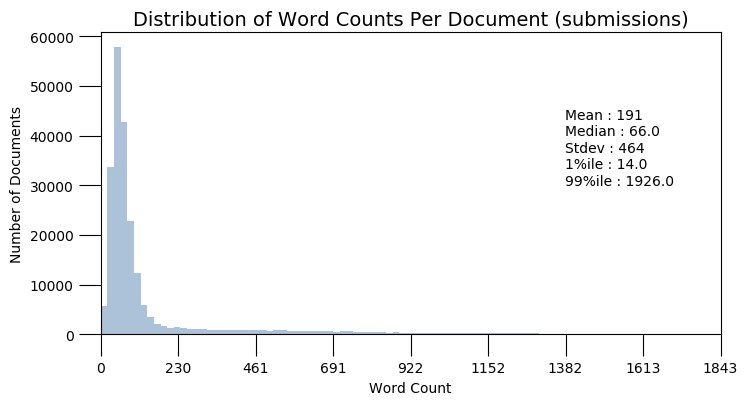

parallel: 27 partitions with 27 cores for length_calc_df


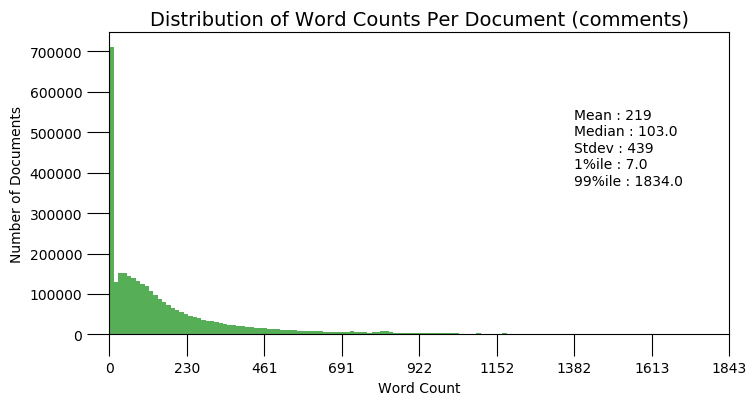

parallel: 27 partitions with 27 cores for length_calc_df


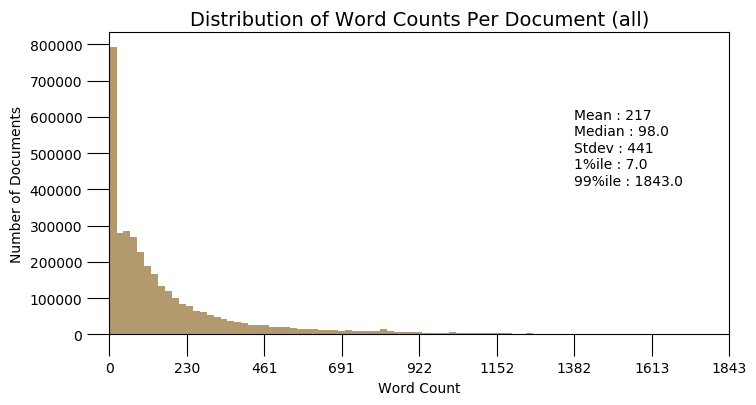

In [10]:
### Plotting histograms of subgroups and group ###

doc_lens=group_len_calc(df_text_orig['all_text'])
doc_size = int(round(np.quantile(doc_lens, q=0.99)))

for index, key in enumerate(list(c.template['files'].keys())):
    df=df_text_orig.loc[df_text_orig['group']==key, 'all_text']
    doc_lens=group_len_calc(df)
#     doc_size = int(round(np.quantile(doc_lens, q=0.99)))
#     plotting_hist(group_len_calc(df), doc_size, key, '#56ae57').show()
    plotting_hist(doc_lens, doc_size, key, list(mcolors.XKCD_COLORS.values())[index]).show()    

if len(c.template['files'].keys()) > 1:
    doc_lens=group_len_calc(df_text_orig['all_text'])
    doc_size = int(round(np.quantile(doc_lens, q=0.99)))
    plotting_hist(doc_lens, 
                  doc_size, 
                  'all', 
                  list(mcolors.XKCD_COLORS.values())[len(c.template['files'].keys())]
                 ).show()